# Shapley, SVERAD and SHAP values for a model system of low dimensionality.

In [1]:
from sverad.sverad_kernel import ExactRBFShapleyComputation, compute_sverad_sv, rbf_kernel
from sverad.utils import set_seeds

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
import pickle
from scipy.stats import pearsonr
from shap import KernelExplainer
from tqdm.auto import tqdm
import warnings

import numpy as np

In [2]:
SEED = 42
set_seeds(SEED)

LOAD_PRECOMPUTED_EXPLANATIONS = False # Set to True to compute random vectors and to False to load precomputed explanations
SAVE_EXPLANATIONS = False # Set to True to save explanations to a pickle file

GAMMA = 1 #set value of gamma for experiments (can define sigma instead and pass it to the functions that accept gamma as a paramenter)
SAMPLE_SIZE = 3 #20 #set sample size for experiments
NUM_FEATURES = 15 #set number of features for experiments
save_path = "./data/pickle/explanations_random_vectors_empty_set_value_experiments.p"
EMPTY_SET_VALUE = 0.0

## Generating random vectors.

In [3]:
r_gen = default_rng(SEED)
random_vectors = r_gen.integers(0,2,(SAMPLE_SIZE,NUM_FEATURES))

## Generating SVs, SVERAD values and SHAP values.
For all pairs SHAP SVERAD and SVs are calculated and compared.

In [4]:

if not LOAD_PRECOMPUTED_EXPLANATIONS:
    explanation_df = []
    # Iterating over all pairs
    for i, vector_i in tqdm(enumerate(random_vectors), total=SAMPLE_SIZE):
        exact_shapley_gen_i = ExactRBFShapleyComputation(vector_i, gamma=GAMMA, empty_set_value=EMPTY_SET_VALUE)
        for j, vector_j in tqdm(enumerate(random_vectors), total=SAMPLE_SIZE):
            shapley_ij = exact_shapley_gen_i.shapley_values(vector_j)

            # intersection_ij = vector_i * vector_j  # Vector where intersecting features are set to 1
            # union_ij = 1 - (1-vector_i) * (1-vector_j)  # Vector where features of the union are set to 1
            # diff_ij = union_ij - intersection_ij  # Vector where features from the symmetric difference are set to 1
            
            # num_intersecting_features = sum(intersection_ij)
            # num_difference_features = sum(diff_ij)

            # sverad_value_f_plus_ij = sverad_f_plus(num_intersecting_features, num_difference_features)
            # sverad_value_f_minus_ij = sverad_f_minus(num_intersecting_features, num_difference_features, gamma=GAMMA)

            # sverad_values_ij = intersection_ij * sverad_value_f_plus_ij + diff_ij * sverad_value_f_minus_ij

            #usubstituting the code above with the function compute_sverad_sv
            sverad_values_ij = compute_sverad_sv(vector_i, vector_j, gamma=GAMMA, empty_set_value=EMPTY_SET_VALUE)

            # Mask to get the 18 other vectors which are not i or j as background.
            mask_background_sample = np.ones(SAMPLE_SIZE, dtype=bool)
            mask_background_sample[i] = False
            mask_background_sample[j] = False
            with warnings.catch_warnings():
                # ignore all caught warnings
                warnings.filterwarnings("ignore")
                explainer_vec_i = KernelExplainer(exact_shapley_gen_i.rbf_kernel_value, random_vectors[mask_background_sample])
                kernel_value = rbf_kernel(vector_i, vector_j, gamma = GAMMA)
                shap_ij = explainer_vec_i.shap_values(vector_j)

            explanation_df.append({"instance a": i,
                                   "instance b": j,
                                    "RBF kernel value": kernel_value,
                                   "Shapley": shapley_ij,
                                   "SVERAD": sverad_values_ij,
                                   "SHAP": shap_ij,
                                   "SHAP_expected_value": explainer_vec_i.expected_value[0],
                                   })
            
        #break # TEST ONLY ONE INSTANCE for testing
    explanation_df = pd.DataFrame(explanation_df)

    if SAVE_EXPLANATIONS:
        with open(save_path, "wb") as outfile:
            pickle.dump(explanation_df, outfile)
else:
    print("Loading precomputed explanations")
    with open(save_path, "rb") as infile:
        explanation_df = pickle.load(infile)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
explanation_df.loc[3]["SHAP"][0].sum() 

0.000290062698140027

In [6]:
# explanation_df.loc[1]["RBF kernel value"] - explanation_df.loc[1]["SHAP_expected_value"]

In [7]:
explanation_df.loc[3]["SVERAD"].sum() 

-4.999664537372097

In [8]:
explanation_df.loc[3]["RBF kernel value"] - EMPTY_SET_VALUE

-4.999664537372097

In [9]:
explanation_df.loc[0]["SVERAD"].sum() + EMPTY_SET_VALUE

0.9999999999999991

In [10]:
explanation_df.loc[3]["Shapley"].sum() 

-4.999664537372436

In [11]:
EMPTY_SET_VALUE

5.0

In [12]:
display(explanation_df)

,instance a,instance b,RBF kernel value,Shapley,SVERAD,SHAP,SHAP_expected_value
0,0,0,1.000000,"[0.0, -0.4444444444444444, -0.4444444444444444...","[0.0, -0.4444444444444444, -0.4444444444444444...","[[0.061457082419101756, 0.04778664343564795, 0...",0.000190
1,0,1,0.000335,"[-0.4326503748638622, -0.30769230769230765, -0...","[-0.43265037486381996, -0.3076923076923077, -0...","[[-0.000362334124074521, 0.000289899865739685,...",0.000045
2,0,2,0.000045,"[0.0, -0.4076877676993753, -0.4076877676993753...","[-0.0, -0.4076877676993315, -0.407687767699331...","[[0.0003623341240745211, -0.000289899865739685...",0.000335
3,1,0,0.000335,"[-0.4326503748638622, -0.30769230769230765, -0...","[-0.43265037486381996, -0.3076923076923077, -0...","[[0.0, 0.0002898998657396854, -0.0003623341240...",0.000045
4,1,1,1.000000,"[-0.4444444444444444, -0.4444444444444444, 0.0...","[-0.4444444444444444, -0.4444444444444444, 0.0...","[[0.12179871953928947, 0.058516946371749055, 0...",0.000190
5,1,2,0.000045,"[-0.4076877676993753, -0.4076877676993753, 0.0...","[-0.4076877676993315, -0.4076877676993315, -0....","[[0.0, -0.0002898998657396855, 0.0003623341240...",0.000335
6,2,0,0.000045,"[0.0, -0.4076877676993753, -0.4076877676993753...","[-0.0, -0.4076877676993315, -0.407687767699331...","[[8.911236841823198e-05, 0.0, -8.9112368418231...",0.000045
7,2,1,0.000045,"[-0.4076877676993753, -0.4076877676993753, 0.0...","[-0.4076877676993315, -0.4076877676993315, -0....","[[-8.911236841823198e-05, 0.0, 8.9112368418231...",0.000045
8,2,2,1.000000,"[0.0, 0.0, 0.0, -0.5714285714285703, -0.571428...","[0.0, 0.0, 0.0, -0.5714285714285714, -0.571428...","[[0.04290578782613707, 0.10345981684230414, 0....",0.000045


#### Pearson r correlation coefficients

In [13]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    shapley_exact = row["Shapley"]
    sverad_value = row["SVERAD"]
    assert all(np.isclose(shapley_exact, sverad_value, 0, 1e-10))
    shap = row["SHAP"][0]
    
    corr_sverad_SV, p_sverad_SV = pearsonr(sverad_value, shapley_exact)
    corr_sverad_SHAP, p_sverad_SHAP = pearsonr(sverad_value, shap)
    corr_SHAP_SV, p_SHAP_SV = pearsonr(shapley_exact, shap)

    corr_df.append({"a": row["instance a"], "b": row["instance b"], "Pearson SVERAD - Exact SV": corr_sverad_SV, "Pearson SVERAD - SHAP": corr_sverad_SHAP, "Pearson SHAP - Exact SV": corr_SHAP_SV})
corr_df = pd.DataFrame(corr_df)
corr_df["Fisher SVERAD - Exact SV"] = np.arctanh(corr_df["Pearson SVERAD - Exact SV"])
corr_df["Fisher SVERAD - SHAP"] = np.arctanh(corr_df["Pearson SVERAD - SHAP"])
corr_df["Fisher SHAP - Exact SV"] = np.arctanh(corr_df["Pearson SHAP - Exact SV"])
display(corr_df)
display(corr_df.mean())
display(corr_df.std())

print("Mean Pearson r correlation coeff Fisher transformed for SVERAD - Exact SV: ", np.tanh(corr_df["Fisher SVERAD - Exact SV"].mean()), "+/-", np.tanh(corr_df["Fisher SVERAD - Exact SV"].std()))
print("Mean Pearson r correlation coeff Fisher transformed for SVERAD - SHAP: ", np.tanh(corr_df["Fisher SVERAD - SHAP"].mean()), "+/-", np.tanh(corr_df["Fisher SVERAD - SHAP"].std()))
print("Mean Pearson r correlation coeff Fisher transformed for SHAP - Exact SV: ", np.tanh(corr_df["Fisher SHAP - Exact SV"].mean()), "+/-", np.tanh(corr_df["Fisher SHAP - Exact SV"].std()))

divide by zero encountered in arctanh


,a,b,Pearson SVERAD - Exact SV,Pearson SVERAD - SHAP,Pearson SHAP - Exact SV,Fisher SVERAD - Exact SV,Fisher SVERAD - SHAP,Fisher SHAP - Exact SV
0,0,1,1.0,0.657280,0.657280,18.714974,0.788009,0.788009
1,0,2,1.0,0.728105,0.728105,inf,0.924682,0.924682
2,1,0,1.0,0.657280,0.657280,18.714974,0.788009,0.788009
3,1,2,1.0,0.728105,0.728105,inf,0.924682,0.924682
4,2,0,1.0,0.679051,0.679051,inf,0.827350,0.827350
5,2,1,1.0,0.679051,0.679051,inf,0.827350,0.827350


a                            1.000000
b                            1.000000
Pearson SVERAD - Exact SV    1.000000
Pearson SVERAD - SHAP        0.688145
Pearson SHAP - Exact SV      0.688145
Fisher SVERAD - Exact SV          inf
Fisher SVERAD - SHAP         0.846680
Fisher SHAP - Exact SV       0.846680
dtype: float64

a                            8.944272e-01
b                            8.944272e-01
Pearson SVERAD - Exact SV    7.021667e-17
Pearson SVERAD - SHAP        3.244792e-02
Pearson SHAP - Exact SV      3.244792e-02
Fisher SVERAD - Exact SV              NaN
Fisher SVERAD - SHAP         6.292933e-02
Fisher SHAP - Exact SV       6.292933e-02
dtype: float64

Mean Pearson r correlation coeff Fisher transformed for SVERAD - Exact SV:  1.0 +/- nan
Mean Pearson r correlation coeff Fisher transformed for SVERAD - SHAP:  0.6893311615737042 +/- 0.06284639153554189
Mean Pearson r correlation coeff Fisher transformed for SHAP - Exact SV:  0.6893311615737471 +/- 0.06284639153554515


#### Old code below

In [14]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    shapley_exact = row["Shapley"]
    sverad_value = row["SVERAD"]
    # Check if all values are closer than 10**-10 to shapley values.
    assert all(np.isclose(shapley_exact, sverad_value, 0, 1e-10))
    shap = row["SHAP"][0]
    
    corr, p = pearsonr(shap, shapley_exact)
    corr_df.append({"a": row["instance a"], "b": row["instance b"], "corrleation": corr})
corr_df = pd.DataFrame(corr_df)
corr_df["pearsons_r_fisher"] = np.arctanh(corr_df.corrleation)

In [15]:
assert corr_df.query("corrleation.isna()").shape[0] == 0

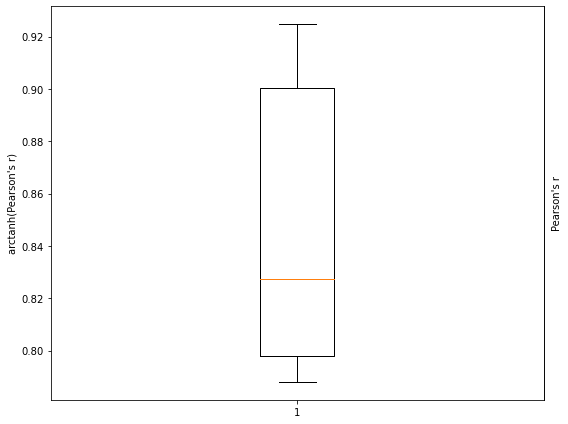

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(corr_df.pearsons_r_fisher)
ax.set_ylabel("arctanh(Pearson's r)")
secax = ax.secondary_yaxis('right', functions=(np.tanh, np.arctanh))
secax.set_ylabel("Pearson's r")
secax.set_yticks([-0.5, 0, 0.5, 0.75, 0.823, 0.9, 0.95, 0.99]);
ax.set_xlabel("")
plt.tight_layout()

In [17]:
np.tanh(corr_df["pearsons_r_fisher"].mean())

0.6893311615737471

In [18]:
np.tanh(corr_df["pearsons_r_fisher"].std())

0.06284639153554515